In [1]:
import torch
from pathlib import Path
import numpy as np
from collections import Counter, OrderedDict


In [2]:
import matplotlib.pyplot as plt
plt.style.use('model/lhcb.mplstyle')

In [3]:
#from model.models import AltCNN4Layer_D35_sp as Model
from model.models_mds_G_simon import AllCNN8Layer_Ca_Two_KDE_withPcnn as Model

from model.collectdata import collect_data, collect_truth
from model.collectdata_poca_KDE import collect_data_poca

from model.plots import plot_truth_vs_predict
from model.efficiency import efficiency, ValueSet, pv_locations, exact_efficiency
from model.efficiency_res import filter_nans_res, efficiency_res, ValueSet_res, pv_locations_res, pv_locations_updated_res, get_resolution, get_nTracks_sorted, get_PVs_label
from model.training import select_gpu
from model.core import modernize_state

#### Device configuration

In [4]:
# device = select_gpu(2)
device = torch.device("cpu")

#### Load a dataset

In [5]:
valfile_ToyMC = Path('/share/lazy/schreihf/PvFinder/Oct03_20K_val.h5')
valfile_FullMC = Path('/share/lazy/sokoloff/ML-data_AA/pv_HLT1CPU_MinBiasMagDown_14Nov.h5')
'''
WARNING ::: The data type of pv_HLT1CPU_MinBiasMagDown_14Nov.h5 and Oct03_20K_val.h5 
            files are different for some variables: i.e. 
           
'''
truth_ToyMC = collect_truth(valfile_ToyMC)
truth_FullMC = collect_truth(valfile_FullMC)

truth_FullMC_svs = collect_truth(valfile_FullMC, pvs=False)

print('-'*100)           
warn_msg = '\nWARNING ::: The data type of pv_HLT1CPU_MinBiasMagDown_14Nov.h5 and Oct03_20K_val.h5 \nfiles are different for some variables: i.e.\n'
print(warn_msg)           
print('Toy  MC true z:',type(truth_ToyMC.z[0][0]))
print('Full MC true z:',type(truth_FullMC.z[0][0]))

warn_msg = '\nThis causes an issue when calling some of the numba functions in model.efficiency_res.py\n'
print(warn_msg)           
print('-'*100)           


Loaded /share/lazy/schreihf/PvFinder/Oct03_20K_val.h5 in 0.02733 s
Loaded /share/lazy/sokoloff/ML-data_AA/pv_HLT1CPU_MinBiasMagDown_14Nov.h5 in 0.03538 s
Loaded /share/lazy/sokoloff/ML-data_AA/pv_HLT1CPU_MinBiasMagDown_14Nov.h5 in 0.1416 s
----------------------------------------------------------------------------------------------------

files are different for some variables: i.e.

Toy  MC true z: <class 'numpy.float32'>
Full MC true z: <class 'numpy.float64'>

This causes an issue when calling some of the numba functions in model.efficiency_res.py

----------------------------------------------------------------------------------------------------


In [6]:
'''
valfile_ToyMC does not have the necessary info to use collect_data_poca for the moment
'''

#validation_ToyMC = collect_data_poca(valfile_ToyMC,
#                                     batch_size=1,
#                                     device=device,
#                                     slice=slice(20000),
#                                     masking=True, shuffle=False,
#                                     load_XandXsq=False,
#                                     load_A_and_B = True,
#                                     load_xy=True)
                
validation_FullMC_mask = collect_data_poca(valfile_FullMC,
                                      batch_size=1,
                                      device=device,
                                      slice=slice(20000),
                                      masking=True, shuffle=False,
                                      load_XandXsq=False,
                                      load_A_and_B = True,
                                      load_xy=True)
                                                    

Loading data...
Loaded /share/lazy/sokoloff/ML-data_AA/pv_HLT1CPU_MinBiasMagDown_14Nov.h5 in 19.22 s
Constructing 20000 event dataset took 0.08512 s


#### Load the model weights

Modernizing old style models if needed.

In [7]:
model = Model().to(device)
model_dict = model.state_dict()
dict_name = 'ML/18December2020_AllCNN8Layer_withPcnn_50epochs_moreDataIter1_lr_5em7_aymm_15p0/18December2020_AllCNN8Layer_withPcnn_50epochs_moreDataIter1_lr_5em7_aymm_15p0_final.pyt'
pretrained_dict = torch.load(dict_name)
model_dict.update(pretrained_dict) 
model.load_state_dict(pretrained_dict,strict=False)
model.eval()

AllCNN8Layer_Ca_Two_KDE_withPcnn(
  (softplus): Softplus(beta=1, threshold=20)
  (leaky): LeakyReLU(negative_slope=0.01)
  (relu): LeakyReLU(negative_slope=0.0)
  (conv1): Conv1d(2, 25, kernel_size=(25,), stride=(1,), padding=(12,))
  (conv2): Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv3): Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv4): Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv5): Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv6): Conv1d(25, 25, kernel_size=(15,), stride=(1,), padding=(7,))
  (conv7): Conv1d(25, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv1dropout): Dropout(p=0.15, inplace=False)
  (conv2dropout): Dropout(p=0.15, inplace=False)
  (conv3dropout): Dropout(p=0.15, inplace=False)
  (conv4dropout): Dropout(p=0.15, inplace=False)
  (conv5dropout): Dropout(p=0.15, inplace=False)
  (conv6dropout): Dropout(p=0.15, inplace=False)
  (conv7dropout): Dropout(p=0.15, inplace=F

#### Compute the model and move results to Numpy

In [8]:
%%time
with torch.no_grad():
    outputs_FullMC_mask = model(validation_FullMC_mask.dataset.tensors[0]).cpu().numpy()
    labels_FullMC_mask = validation_FullMC_mask.dataset.tensors[1].cpu().numpy()    

x0 =  tensor([[2.5380e-29, 1.0837e-31, 2.6848e-34,  ..., 6.5229e-18, 2.4051e-17,
         6.0671e-17],
        [7.2615e-29, 3.7873e-31, 1.2248e-33,  ..., 6.5229e-18, 2.4051e-17,
         6.0671e-17],
        [2.5380e-29, 1.0837e-31, 2.6848e-34,  ..., 6.5229e-18, 2.4051e-17,
         6.0671e-17],
        ...,
        [4.4202e-28, 3.1779e-30, 1.6454e-32,  ..., 6.5229e-18, 2.4051e-17,
         6.0671e-17],
        [2.7596e-29, 1.1924e-31, 3.0095e-34,  ..., 6.5229e-18, 2.4051e-17,
         6.0671e-17],
        [2.5380e-29, 1.0837e-31, 2.6848e-34,  ..., 6.5229e-18, 2.4051e-17,
         6.0671e-17]])
x1 =  tensor([[ 0.1092,  0.1095,  0.1098,  ..., -0.0398, -0.0137,  0.0103],
        [ 0.0513,  0.0315,  0.0087,  ..., -0.0398, -0.0137,  0.0103],
        [ 0.1092,  0.1095,  0.1098,  ..., -0.0398, -0.0137,  0.0103],
        ...,
        [ 0.0561,  0.0395,  0.0200,  ..., -0.0398, -0.0137,  0.0103],
        [ 0.0057, -0.0218, -0.0536,  ..., -0.0398, -0.0137,  0.0103],
        [ 0.1092,  0.1095,  0

In [9]:
nsig_res = 5
min_res = 0.0
threshold = 0.06
integral_threshold = 0.75
min_width = 0

eff_settings_res_top = dict(
                        nsig_res=nsig_res, # number of sigmas from original res(nTracks)
                        min_res=min_res, # 
                        threshold=threshold,
                        integral_threshold=integral_threshold,
                        min_width = min_width, #bins
                        debug = 0,     # bins
                        )

pv_loc_settings_top = dict(
    threshold=threshold,
    integral_threshold=integral_threshold,
    min_width=min_width# bins
)




i_r_max_cut: 1.5
i_delta_bins_cut: 20

Event 176

reco_PVs_loc: [  72.69404  782.12537 1064.3005  1349.6979 ]
reco_PVs_labels: [1 1 1 0]
true_PVs_loc: [  72.412025  781.5529   1063.4109   1359.4109  ]
true_PVs_nTracks: [28, 37, 13, 11]
resolutions: [3.3531768 2.7649317 5.903693  6.712477 ]
52 8.731116e-22
53 3.816523e-18
54 7.341718e-17
55 1.9125106e-17
56 6.9959715e-19
57 6.2534334e-22
58 4.277577e-28
59 2.3152653e-30
60 4.688673e-25
61 5.496241e-20
62 4.1898433e-20
63 1.6838942e-24
64 1.0834869e-27
65 8.4958e-19
66 9.074845e-10
67 1.6438053e-05
68 0.0016099326
69 0.039188012
70 0.30798748
71 0.80471325
72 1.1411093
73 0.9130093
74 0.45688984
75 0.105852365
76 0.0077269687
77 0.00020804536
78 1.6547857e-07
79 1.1617643e-14
80 4.581286e-25
81 9.534286e-28
82 1.645384e-22
83 8.2203514e-19
84 1.817595e-18
85 1.9662626e-20
86 6.7143126e-23
87 1.4333822e-23
88 4.730475e-23
89 1.4106322e-22
90 2.857278e-22
91 8.143634e-23
ibin_min = 70
ibin_max = 74
width = 4
762 1.702232e-21
763 2.17849

'            \n    if show_statements:\n        if 0 in reco_PVs_labels:\n            print("\nEvent",i)\n            print("\nTrue PVs n    :",sorted_true_PVs_n)\n            print("Resolution    :",resolution)\n            print("\nTrue PVs z    :",true_PVs_loc)\n\n            print("Reco PVs z    :",reco_PVs_loc)\n            print("Reco PVs label:",reco_PVs_labels)\n\n            print("True PVs label:",true_PVs_labels)\n\n\nprint(total.pretty())\nprint("\nFP_tot",FP_tot)\nprint("FP_removed",FP_removed)\nprint("FP_kept",FP_tot-FP_removed)\nprint("\nS_tot",S_tot)\nprint("S_removed",S_removed)\nprint("S_kept",S_tot-S_removed)\nprint("\nNew eff =",(S_tot-S_removed)/float(S_tot)*total.eff_rate)\nprint("New fp_rate =",(FP_tot-FP_removed)/float(FP_tot)*total.fp_rate)\n#d_eff[i_r_max_cut][i_delta_bins_cut]=(S_tot-S_removed)/float(S_tot)*total.eff_rate\n#d_fp[i_r_max_cut][i_delta_bins_cut]=(FP_tot-FP_removed)/float(FP_tot)*total.fp_rate\n'

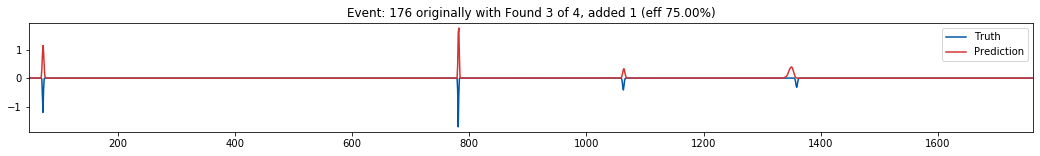

In [54]:
show_statements = False

total = ValueSet_res(0,0,0,0)

delta_reco_PVs_loc_all = np.ndarray(0,dtype=float)
delta_reco_FP_loc_all = np.ndarray(0,dtype=float)
delta_reco_S_loc_all = np.ndarray(0,dtype=float)

delta_true_PVs_loc_all = np.ndarray(0,dtype=float)

true_PVs_width = np.ndarray(0,dtype=float)
true_PVs_reso = np.ndarray(0,dtype=float)



delta_reco_FP_loc_only = np.ndarray(0,dtype=float)
reco_FP_max_only = np.ndarray(0,dtype=float)
reco_FP_closest_max_only = np.ndarray(0,dtype=float)
reco_FP_r_max_only = np.ndarray(0,dtype=float)
reco_FP_r_int_only = np.ndarray(0,dtype=float)
reco_FP_width_only = np.ndarray(0,dtype=float)
reco_FP_max_over_width_only = np.ndarray(0,dtype=float)

delta_reco_S_loc_only = np.ndarray(0,dtype=float)
reco_S_max_only = np.ndarray(0,dtype=float)
reco_S_closest_max_only = np.ndarray(0,dtype=float)
reco_S_r_max_only = np.ndarray(0,dtype=float)
reco_S_r_int_only = np.ndarray(0,dtype=float)
reco_S_width_only = np.ndarray(0,dtype=float)
reco_S_max_over_width_only = np.ndarray(0,dtype=float)

reco_PVs_width = np.ndarray(0,dtype=float)

best_r_max_cut=0
best_delta_bins_cut=0

d_eff={}
d_fp={}

#for i_r_max_cut in [x * 0.1 for x in range(0, 40)]:
#    d_eff[i_r_max_cut]={}
#    d_fp[i_r_max_cut]={}
#    for i_delta_bins_cut in range(0,50):
i_r_max_cut=1.5
i_delta_bins_cut=20

print("\n")
print("="*50)
print("\ni_r_max_cut:",i_r_max_cut)
print("i_delta_bins_cut:",i_delta_bins_cut)

FP_tot = 0
FP_removed = 0

S_tot = 0
S_removed = 0

for iEvt in range(176,177):

    true_PVs_nTracks = truth_FullMC.n[iEvt]
    true_PVs_z = truth_FullMC.z[iEvt]
    sorted_true_PVs_z = [(i[0]+100)*10 for i in sorted( zip((true_PVs_z[true_PVs_nTracks > 4]), true_PVs_nTracks[true_PVs_nTracks > 4]))]
    sorted_true_PVs_n = [i[1] for i in sorted( zip((true_PVs_z[true_PVs_nTracks > 4]), true_PVs_nTracks[true_PVs_nTracks > 4]))]


    result = efficiency_res(labels_FullMC_mask[iEvt], outputs_FullMC_mask[iEvt], truth_FullMC.n[iEvt], truth_FullMC.z[iEvt], **eff_settings_res_top)
    total+=result
    true_PVs_loc = pv_locations_res(labels_FullMC_mask[iEvt], **pv_loc_settings_top)
    reco_PVs_loc = pv_locations_res(outputs_FullMC_mask[iEvt], **pv_loc_settings_top)
    reco_PVs_loc = filter_nans_res(reco_PVs_loc,labels_FullMC_mask[iEvt])

    true_PVs_labels = get_PVs_label(0,labels_FullMC_mask[iEvt], outputs_FullMC_mask[iEvt], truth_FullMC.n[iEvt], truth_FullMC.z[iEvt],nsig_res,min_res,threshold,integral_threshold,min_width,0)
    reco_PVs_labels = get_PVs_label(1,labels_FullMC_mask[iEvt], outputs_FullMC_mask[iEvt], truth_FullMC.n[iEvt], truth_FullMC.z[iEvt],nsig_res,min_res,threshold,integral_threshold,min_width,0)

    
    
    resolution = get_resolution(true_PVs_loc, true_PVs_nTracks, true_PVs_z, nsig_res, min_res, 0)

    for true_pv in range(len(true_PVs_loc)):
        
        true_PVs_loc_ibin = int(true_PVs_loc[true_pv])

        width = 999.

        true_PVs_max = labels_FullMC_mask[iEvt][true_PVs_loc_ibin]
        ibin_min = -1
        ibin_max = -1
        for ibin in range(true_PVs_loc_ibin,true_PVs_loc_ibin-20,-1):
            true_PVs_val = labels_FullMC_mask[iEvt][ibin]
            if true_PVs_val<true_PVs_max/2.:
                ibin_min = ibin
                break
        for ibin in range(true_PVs_loc_ibin,true_PVs_loc_ibin+20):
            true_PVs_val = labels_FullMC_mask[iEvt][ibin]
            if true_PVs_val<true_PVs_max/2.:
                ibin_max = ibin
                break
        #print("ibin_min =",ibin_min)
        #print("ibin_max =",ibin_max)
        width = (ibin_max-ibin_min)

        
        true_PVs_width = np.append([width],true_PVs_width)
        true_PVs_reso = np.append([resolution[true_pv]],true_PVs_reso)
    
    ## =========== PRINTS ========= 


    # ====================================
    # --  delta_z between next FP and Success PVS 
    if len(reco_PVs_loc)==0 or len(true_PVs_loc)==0:
        continue

    delta_reco_PVs_loc = np.zeros(len(reco_PVs_loc)-1,dtype=float)

    delta_reco_FP_l = []
    delta_reco_S_l = []
    for j in range(len(reco_PVs_loc)-1):
        delta_reco_PVs_loc[j] = (reco_PVs_loc[j+1]-reco_PVs_loc[j])        
        if reco_PVs_labels[j]==0:
            delta_reco_FP_l.append(delta_reco_PVs_loc[j])
        else:
            delta_reco_S_l.append(delta_reco_PVs_loc[j])

    delta_reco_PVs_loc_all = np.append(delta_reco_PVs_loc_all,delta_reco_PVs_loc)

    delta_reco_FP_loc = np.zeros(len(delta_reco_FP_l),dtype=float)
    for j in range(len(delta_reco_FP_l)):
        delta_reco_FP_loc[j] = delta_reco_FP_l[j]
    delta_reco_FP_loc_all = np.append(delta_reco_FP_loc_all,delta_reco_FP_loc)

    delta_reco_S_loc = np.zeros(len(delta_reco_S_l),dtype=float)
    for j in range(len(delta_reco_S_l)):
        delta_reco_S_loc[j] = delta_reco_S_l[j]
    delta_reco_S_loc_all = np.append(delta_reco_S_loc_all,delta_reco_S_loc)


    # ====================================
    # --  delta_z between next true PVS 
    delta_true_PVs_loc = np.zeros(len(true_PVs_loc)-1,dtype=float)
    for j in range(len(true_PVs_loc)-1):
        delta_true_PVs_loc[j] = (true_PVs_loc[j+1]-true_PVs_loc[j])
    delta_true_PVs_loc_all = np.append(delta_true_PVs_loc_all,delta_true_PVs_loc)



    # ====================================
    # ====================================
    # ====================================
    #if 0 in true_PVs_labels and sum(true_PVs_labels)==sum(reco_PVs_labels):
    if show_statements:
        print("\nEvent",iEvt)
        print("\nreco_PVs_loc:",reco_PVs_loc)
        print("reco_PVs_labels:",reco_PVs_labels)

    print("="*80)
    print("\nEvent",iEvt)
    print("\nreco_PVs_loc:",reco_PVs_loc)
    print("reco_PVs_labels:",reco_PVs_labels)
    print("true_PVs_loc:",true_PVs_loc)
    print("true_PVs_nTracks:",sorted_true_PVs_n)
    print("resolutions:",resolution)

    reco_ipv = []
    closest_ipv = []
    S_reco_pv = 0

    l_removed_ipvs = []
    
    N_FP = len(reco_PVs_labels)-sum(reco_PVs_labels)
    #print("N_FP",N_FP)
    for reco_pv in range(len(reco_PVs_labels)):

        # ************************
        # Get the width of all reco PVs
        # ************************

        reco_PVs_loc_ibin = int(reco_PVs_loc[reco_pv])
        reco_PVs_max = outputs_FullMC_mask[iEvt][reco_PVs_loc_ibin]
        ibin_min = -1
        ibin_max = -1
        for ibin in range(reco_PVs_loc_ibin,reco_PVs_loc_ibin-20,-1):
            reco_PVs_val = outputs_FullMC_mask[iEvt][ibin]
            if reco_PVs_val<reco_PVs_max/2.:
                ibin_min = ibin
                break
        for ibin in range(reco_PVs_loc_ibin,reco_PVs_loc_ibin+20):
            reco_PVs_val = outputs_FullMC_mask[iEvt][ibin]
            if reco_PVs_val<reco_PVs_max/2.:
                ibin_max = ibin
                break

        width = (ibin_max-ibin_min)

        for ibin in range(reco_PVs_loc_ibin-20,reco_PVs_loc_ibin+20):
            print(ibin,outputs_FullMC_mask[iEvt][ibin])
            
        print("ibin_min =",ibin_min)
        print("ibin_max =",ibin_max)
        print("width =",width)

        reco_PVs_width = np.append([width],reco_PVs_width)
        
        reco_PVs_max_over_width=999
        if not width==0:
            reco_PVs_max_over_width = reco_PVs_max/float(width)
            
        # ************************
        # Get all reco "pairs" infos (excluding FPs)
        # ************************

        #if (reco_PVs_labels[reco_pv]==1):
        #reco_PVs_loc_ibin = int(reco_PVs_loc[reco_pv])

        # Get the closest matched reconstructed PV infos and associated true PV infos
        closest_reco_PVs_loc_ibin = -99
        if len(reco_PVs_labels)==1:
            closest_reco_PVs_loc_ibin = -1

        else:
            # Reco PV is first in the list, check next ones only
            if reco_pv==0:
                for iPVs in range(1,len(reco_PVs_labels)):
                    if reco_PVs_labels[iPVs]==1:
                        closest_reco_PVs_loc_ibin = int(reco_PVs_loc[iPVs])
                        break

            # Reco is last PV in the list, check previous ones only
            elif reco_pv==(len(reco_PVs_labels)-1):
                for iPVs in range(reco_pv,0,-1):
                    if iPVs==reco_pv:
                        continue
                    if reco_PVs_labels[iPVs]==1:
                        closest_reco_PVs_loc_ibin = int(reco_PVs_loc[iPVs])
                        break

            # Reco is neither first nore last PV in the list, check next AND previous 
            # ones to decide which one is closest
            else:
                next_reco_PVs_loc_ibin = -1 
                for iPVs in range(reco_pv,len(reco_PVs_labels)):
                    if iPVs==reco_pv:
                        continue
                    if reco_PVs_labels[iPVs]==1:
                        next_reco_PVs_loc_ibin = int(reco_PVs_loc[iPVs])
                        break
                previous_reco_PVs_loc_ibin = -1 
                for iPVs in range(reco_pv,0,-1):
                    if iPVs==reco_pv:
                        continue
                    if reco_PVs_labels[iPVs]==1:
                        previous_reco_PVs_loc_ibin = int(reco_PVs_loc[iPVs])
                        break
                delta_next = next_reco_PVs_loc_ibin - reco_PVs_loc_ibin
                delta_prev = reco_PVs_loc_ibin - previous_reco_PVs_loc_ibin

                if delta_next < delta_prev:
                    closest_reco_PVs_loc_ibin = next_reco_PVs_loc_ibin
                else:
                    closest_reco_PVs_loc_ibin = previous_reco_PVs_loc_ibin

        # Now look at the ratios between the FP and closest matched reco PV max KDE, and integral (+/- 2 bins from max) 

        # First get the actual FP max and max ibin
        reco_PVs_max = outputs_FullMC_mask[iEvt][reco_PVs_loc_ibin]
        reco_PVs_max_ibin = reco_PVs_loc_ibin

        reco_PVs_int = 0

        for ibin in range(reco_PVs_loc_ibin-2,reco_PVs_loc_ibin+2):
            reco_PVs_int += outputs_FullMC_mask[iEvt][ibin]

            if outputs_FullMC_mask[iEvt][ibin] > reco_PVs_max:
                reco_PVs_max = outputs_FullMC_mask[iEvt][ibin]
                reco_PVs_max_ibin = ibin


        # Now get the actual closest matched PV max and max ibin
        closest_reco_PVs_max = outputs_FullMC_mask[iEvt][closest_reco_PVs_loc_ibin]
        closest_reco_PVs_max_ibin = closest_reco_PVs_loc_ibin

        closest_reco_PVs_int = 0

        for ibin in range(closest_reco_PVs_loc_ibin-2,closest_reco_PVs_loc_ibin+2):
            closest_reco_PVs_int += outputs_FullMC_mask[iEvt][ibin]
            if outputs_FullMC_mask[iEvt][ibin] > closest_reco_PVs_max:
                closest_reco_PVs_max = outputs_FullMC_mask[iEvt][ibin]
                closest_reco_PVs_max_ibin = ibin

        r_max = 0
        if not reco_PVs_max==0:
            r_max=closest_reco_PVs_max/reco_PVs_max

        r_int = 0
        if not reco_PVs_int==0:
            r_int=closest_reco_PVs_int/reco_PVs_int

        # Store the outputs depending on the reco PV label
        if (reco_PVs_labels[reco_pv]==1):

            # Record the reco PV width and ratio max over width
            reco_S_width_only = np.append([width],reco_S_width_only)
            reco_S_max_over_width_only = np.append([reco_PVs_max_over_width],reco_S_max_over_width_only)
            
            if abs(closest_reco_PVs_loc_ibin-reco_PVs_loc_ibin)<i_delta_bins_cut and r_max>i_r_max_cut:
                S_removed+=1
                l_removed_ipvs.append(reco_pv)
                
            S_tot+=1

            # Store the bin of the reco and closest PVs for clone removal
            reco_ipv.append(reco_PVs_loc_ibin)
            closest_ipv.append(closest_reco_PVs_loc_ibin)

            if S_reco_pv==0:
                #print("\nreco_PVs_loc_ibin",reco_PVs_loc_ibin)
                #print("closest_reco_PVs_loc_ibin",closest_reco_PVs_loc_ibin)
                delta_reco_S_loc_only = np.append([abs(closest_reco_PVs_loc_ibin-reco_PVs_loc_ibin)],delta_reco_S_loc_only)
                reco_S_r_max_only = np.append([r_max],reco_S_r_max_only)
                reco_S_max_only = np.append([reco_PVs_max],reco_S_max_only)
                reco_S_closest_max_only = np.append([reco_PVs_max],reco_S_max_only)
                reco_S_r_int_only = np.append([r_int],reco_S_r_int_only)
            else:                
                if not (reco_ipv[S_reco_pv]==closest_ipv[S_reco_pv-1] and closest_ipv[S_reco_pv]==reco_ipv[S_reco_pv-1]):
                    delta_reco_S_loc_only = np.append([abs(closest_reco_PVs_loc_ibin-reco_PVs_loc_ibin)],delta_reco_S_loc_only)
                    reco_S_r_max_only = np.append([r_max],reco_S_r_max_only)
                    reco_S_max_only = np.append([reco_PVs_max],reco_S_max_only)
                    reco_S_r_int_only = np.append([r_int],reco_S_r_int_only)
#                    print("\nFirst pair (storing info):")    
#                    print("\nreco_PVs_loc_ibin",reco_PVs_loc_ibin)
#                    print("closest_reco_PVs_loc_ibin",closest_reco_PVs_loc_ibin)
#                    
#                else:
#                    print("\nClone pair with previous one:")
#                    print("\nreco_PVs_loc_ibin",reco_PVs_loc_ibin)
#                    print("closest_reco_PVs_loc_ibin",closest_reco_PVs_loc_ibin)

            S_reco_pv+=1

        else:
            
            # Condition to remove the FP that are reflections of true PVs and already accounted for by another reco PV 
            if abs(closest_reco_PVs_loc_ibin-reco_PVs_loc_ibin)<i_delta_bins_cut and r_max>i_r_max_cut:
                FP_removed+=1
                N_FP-=1
                l_removed_ipvs.append(reco_pv)

            else:
                # Record the reco PV width and ratio max over width
                reco_FP_width_only = np.append([width],reco_FP_width_only)
                reco_FP_max_over_width_only = np.append([reco_PVs_max_over_width],reco_FP_max_over_width_only)
                
            FP_tot+=1

            delta_reco_FP_loc_only = np.append([abs(closest_reco_PVs_loc_ibin-reco_PVs_loc_ibin)],delta_reco_FP_loc_only)
            reco_FP_r_max_only = np.append([r_max],reco_FP_r_max_only)
            reco_FP_max_only = np.append([reco_PVs_max],reco_FP_max_only)
            reco_FP_r_int_only = np.append([r_int],reco_FP_r_int_only)

    if N_FP>0:
        ax = plot_truth_vs_predict(labels_FullMC_mask[iEvt], outputs_FullMC_mask[iEvt])

        str_removed_pvs_loc = ""
        for ipv in l_removed_ipvs:
            typePV = "FP"
            if reco_PVs_labels[ipv]==1:
                typePV = "S"
                
            str_removed_pvs_loc += "%s at bin(%s)"%(typePV,reco_PVs_loc[ipv])
        if len(l_removed_ipvs)>0:
            ax.set_title("Event: "+str(iEvt)+" originally with "+str(result)+" and after reflections removal: "+str(str_removed_pvs_loc))
        else:
            ax.set_title("Event: "+str(iEvt)+" originally with "+str(result))
"""            
    if show_statements:
        if 0 in reco_PVs_labels:
            print("\nEvent",i)
            print("\nTrue PVs n    :",sorted_true_PVs_n)
            print("Resolution    :",resolution)
            print("\nTrue PVs z    :",true_PVs_loc)

            print("Reco PVs z    :",reco_PVs_loc)
            print("Reco PVs label:",reco_PVs_labels)

            print("True PVs label:",true_PVs_labels)


print(total.pretty())
print("\nFP_tot",FP_tot)
print("FP_removed",FP_removed)
print("FP_kept",FP_tot-FP_removed)
print("\nS_tot",S_tot)
print("S_removed",S_removed)
print("S_kept",S_tot-S_removed)
print("\nNew eff =",(S_tot-S_removed)/float(S_tot)*total.eff_rate)
print("New fp_rate =",(FP_tot-FP_removed)/float(FP_tot)*total.fp_rate)
#d_eff[i_r_max_cut][i_delta_bins_cut]=(S_tot-S_removed)/float(S_tot)*total.eff_rate
#d_fp[i_r_max_cut][i_delta_bins_cut]=(FP_tot-FP_removed)/float(FP_tot)*total.fp_rate
"""

In [11]:
453./26171 / 0.0035

4.945495832355333

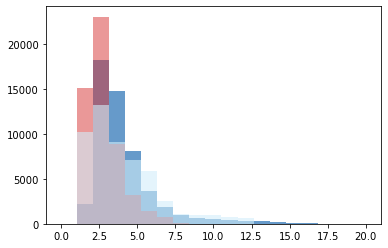

'\ndiff_plot = plt.hist(true_PVs_width,bins)        \nplt.show()\ndiff_plot = plt.hist(true_PVs_reso,bins)        \nplt.show()\nnTcks_res_plot = plt.hist2d(true_PVs_width, true_PVs_reso,bins=100)        \nplt.colorbar()\nplt.show()\n'

In [44]:
bins = np.linspace(0, 20, 20)

plt.hist(reco_PVs_width,bins, alpha=0.6)        
#plt.hist(reco_S_width_only,bins, alpha=0.6)        
#plt.hist(reco_FP_width_only,bins, alpha=0.6)        
plt.hist(true_PVs_width,bins, alpha=0.5)        
plt.hist(true_PVs_reso,bins, alpha=0.6)        
#plt.yscale('log')
plt.show()
'''
diff_plot = plt.hist(true_PVs_width,bins)        
plt.show()
diff_plot = plt.hist(true_PVs_reso,bins)        
plt.show()
nTcks_res_plot = plt.hist2d(true_PVs_width, true_PVs_reso,bins=100)        
plt.colorbar()
plt.show()
'''


In [ ]:
diff_plot = plt.hist(reco_FP_width_only,bins=20)        
plt.show()
diff_plot = plt.hist(reco_S_width_only,bins=20)        
plt.show()

In [ ]:
diff_plot = plt.hist(reco_FP_max_over_width_only[reco_FP_width_only>10],bins=20)        
plt.show()
diff_plot = plt.hist(reco_S_max_over_width_only[reco_S_width_only>10],bins=20)        
plt.show()

In [ ]:

arr_FPn = np.where((reco_FP_r_max_only>0.0) | (delta_reco_FP_loc_only>0))
arr_Sn = np.where((reco_S_r_max_only>0.0) | (delta_reco_S_loc_only>0))

N_FPn = len(arr_FPn[0])
N_Sn = len(arr_Sn[0])
print("N_FPn",N_FPn)
print("N_Sn",N_Sn)

best_r_max_cut=0
best_delta_bins_cut=0

max_eff=0
min_fp=1

base_eff = total.eff_rate
base_fp = total.fp_rate
print("base_eff",base_eff)
print("base_fp",base_fp)

for i_r_max_cut in [x * 0.1 for x in range(0, 100)]:
    for i_delta_bins_cut in range(0,100):

        arr_FPc = np.where((reco_FP_r_max_only>i_r_max_cut) | (delta_reco_FP_loc_only>i_delta_bins_cut))
        arr_Sc = np.where((reco_S_r_max_only>i_r_max_cut) | (delta_reco_S_loc_only>i_delta_bins_cut))

        N_FPc = len(arr_FPc[0])
        N_Sc = len(arr_Sc[0])

        eff = base_eff*(N_Sc/N_Sn)
        fp = base_fp*(N_FPc/N_FPn)

        if (eff - fp)>(max_eff - min_fp):
            max_eff=eff
            min_fp=fp
            best_r_max_cut=i_r_max_cut
            best_delta_bins_cut=i_delta_bins_cut


            
print("\neff",max_eff)            
print("fp",min_fp)            
print("eff-fp",max_eff-min_fp)            
print("\nbest_r_max_cut",best_r_max_cut)            
print("best_delta_bins_cut",best_delta_bins_cut)


In [ ]:
r_max_cut=1.0
delta_bins_cut=20

arr_FPc = np.where((reco_FP_r_max_only>r_max_cut) & (delta_reco_FP_loc_only>delta_bins_cut))
arr_Sc = np.where((reco_S_r_max_only>r_max_cut) & (delta_reco_S_loc_only>delta_bins_cut))

N_FPc = len(arr_FPc[0])
N_Sc = len(arr_Sc[0])

eff = N_Sc/float(N_Sn)
fp = N_FPc/float(N_FPn)

print("\neff",eff)            
print("fp",fp)            
print("eff-fp",eff-fp)            


In [ ]:
r_max_cut=0.0
delta_bins_cut=0

arr_FPc = np.where((reco_FP_r_max_only>r_max_cut) & (delta_reco_FP_loc_only>delta_bins_cut))

diff_plot = plt.hist(arr_FPc[0],bins=20)        
plt.show()

In [ ]:
diff_plot = plt.hist(delta_reco_PVs_loc_all[delta_reco_PVs_loc_all<100],bins=20)        
plt.show()

In [ ]:
diff_plot = plt.hist(delta_true_PVs_loc_all[delta_true_PVs_loc_all<100],bins=20)        
plt.show()

In [ ]:
diff_plot = plt.hist(delta_reco_FP_loc_all[delta_reco_FP_loc_all<30],bins=20)        
plt.show()

In [ ]:
diff_plot = plt.hist(delta_reco_S_loc_all[delta_reco_S_loc_all>200],bins=150)        
plt.show()

In [ ]:
diff_plot = plt.hist(delta_reco_FP_loc_only[delta_reco_FP_loc_only>200],bins=150)        
plt.show()

In [ ]:
diff_plot = plt.hist(delta_reco_FP_loc_only[delta_reco_FP_loc_only>20],bins=50)        
plt.show()

In [ ]:
diff_plot = plt.hist(delta_reco_S_loc_only[delta_reco_S_loc_only>20],bins=50)        
plt.show()

In [ ]:
ratio = plt.hist(reco_FP_r_max_only[delta_reco_FP_loc_only<25],bins=25)        
plt.show()

In [ ]:
ratio = plt.hist(reco_S_r_max_only[delta_reco_S_loc_only<25],bins=25)        
plt.show()

In [ ]:
ratio = plt.hist(reco_FP_max_only[delta_reco_FP_loc_only<25],bins=100)        
plt.show()

In [ ]:
ratio = plt.hist(reco_S_max_only[delta_reco_S_loc_only<25],bins=100)        
plt.show()

In [ ]:
ratio = plt.hist(reco_FP_r_int_only[reco_FP_r_int_only<=100],bins=100)        
plt.show()

In [ ]:
ratio = plt.hist(reco_S_r_int_only[reco_S_r_int_only<=100],bins=100)        
plt.show()

In [ ]:
from math import *
nTcks_res_plot = plt.hist2d(reco_FP_r_int_only[reco_FP_r_int_only<=10], reco_FP_r_max_only[reco_FP_r_int_only<=10],bins=30)        
plt.colorbar()
plt.show()


In [ ]:
from math import *
nTcks_res_plot = plt.hist2d(reco_S_r_int_only[reco_S_r_int_only<=10], reco_S_r_max_only[reco_S_r_int_only<=10],bins=30)        
plt.colorbar()
plt.show()


In [ ]:
plot_FP = plt.hist2d(reco_FP_r_max_only[delta_reco_FP_loc_only>20], delta_reco_FP_loc_only[delta_reco_FP_loc_only>20],bins=30)        
plt.colorbar()
plt.show()
plot_S = plt.hist2d(reco_S_r_max_only[delta_reco_S_loc_only>20], delta_reco_S_loc_only[delta_reco_S_loc_only>20],bins=30)        
plt.colorbar()
plt.show()


In [ ]:
#nTcks_res_plot = plt.hist2d(reco_FP_r_int_only[delta_reco_FP_loc_only<50], delta_reco_FP_loc_only[delta_reco_FP_loc_only<50],bins=30)        
#plt.colorbar()
#plt.show()


In [ ]:
from math import *
nTcks_res_plot = plt.hist2d(reco_S_r_max_only[delta_reco_S_loc_only<50], delta_reco_S_loc_only[delta_reco_S_loc_only<50],bins=30)        
plt.colorbar()
plt.show()


In [ ]:
from math import *
nTcks_res_plot = plt.hist2d(reco_S_r_int_only[delta_reco_S_loc_only<50], delta_reco_S_loc_only[delta_reco_S_loc_only<50],bins=30)        
plt.colorbar()
plt.show()


In [ ]:
print(len(delta_reco_FP_loc_only[delta_reco_FP_loc_only>50])/float(len(delta_reco_FP_loc_only)))
print(len(delta_reco_S_loc_all[delta_reco_S_loc_all>50])/float(len(delta_reco_S_loc_all)))
print(len(reco_FP_r_max_only[reco_FP_r_max_only>1])/float(len(delta_reco_FP_loc_only)))

In [ ]:
print(len(reco_FP_r_max_only[reco_FP_r_max_only>1.0])/float(len(reco_FP_r_max_only)))
print(len(reco_S_r_max_only[reco_S_r_max_only>1.0])/float(len(reco_S_r_max_only)))

In [ ]:
len(delta_reco_FP_loc_only[delta_reco_FP_loc_only>50])

In [ ]:
i_delta_bins_cut=-10000
i_r_max_cut=2
arr_FPc = np.where((reco_FP_r_max_only>i_r_max_cut) & (delta_reco_FP_loc_only>i_delta_bins_cut))
print(len(arr_FPc[0]))

In [ ]:
nTrcks_min = -1

true_PVs_z = truth_FullMC.z[18]
true_PVs_nTracks = truth_FullMC.n[18]

true_SVs_z = truth_FullMC_svs.z[18]
true_SVs_n = truth_FullMC_svs.n[18]
true_SVs_c = truth_FullMC_svs.cat[18]

sorted_true_SVs_z = sorted(true_SVs_z)
sorted_true_SVs_n = [i[1] for i in sorted( zip((true_SVs_z[true_SVs_n > nTrcks_min]), true_SVs_n[true_SVs_n > nTrcks_min]))]

print(sorted_true_SVs_z)
print(sorted_true_SVs_n)
print(true_SVs_c)

for i in sorted( zip((true_SVs_z[true_SVs_n > nTrcks_min]), true_SVs_n[true_SVs_n > nTrcks_min])):
    print((i[0]+100)*10,i[1])




In [ ]:
filtered_and_sorted_true_PVs_nTracks = [i[1] for i in sorted( zip((true_PVs_z[true_PVs_nTracks > nTrcks_min]), true_PVs_nTracks[true_PVs_nTracks > nTrcks_min]))]
filtered_and_sorted_true_PVs_z = [i[0] for i in sorted( zip((true_PVs_z[true_PVs_nTracks > nTrcks_min]), true_PVs_nTracks[true_PVs_nTracks > nTrcks_min]))]
filtered_and_sorted_true_PVs_z_bins = [((i+100)*10) for i in filtered_and_sorted_true_PVs_z]
filtered_and_sorted_true_SVs_z_bins = [((i+100)*10) for i in sorted(true_SVs_z)]

print(truth_FullMC.cat[18])
print(true_PVs_nTracks)
print(true_PVs_z)
print(filtered_and_sorted_true_PVs_nTracks)
print(filtered_and_sorted_true_PVs_z)
print(filtered_and_sorted_true_PVs_z_bins)


In [ ]:
for i in range(len(labels_FullMC_mask[18])):
    print(i,labels_FullMC_mask[18][i],labels_FullMC[18][i],outputs_FullMC_mask[18][i],outputs_FullMC[18][i])
print(truth_FullMC.n[18])



#### Compute the efficencies over the dataset

In [ ]:
eff_settings_res_top = dict(
                        nsig_res = 5, # number of sigmas from original res(nTracks)
                        min_res = 0.0, # 
                        threshold = 0.06,
                        integral_threshold = 0.75,
                        min_width = 0, # bins
                        debug = 0,     # bins
                        )

global_min_res = 3.0
pv_loc_settings_top = dict(
    threshold = 0.06,
    integral_threshold = 0.75,
    min_width = 0    # bins
)

eff_settings = dict(
    difference = 5., # bins
    threshold = 1e-2,
    integral_threshold = .2,
    min_width = 3    # bins
)

eff_settings_nodiff = eff_settings.copy()
del eff_settings_nodiff['difference']

In [ ]:
%%time
total = ValueSet(0,0,0,0)
i=0
for label, output in zip(labels_FullMC, outputs_FullMC):
    total += efficiency(label, output, **eff_settings)
    if i<20:
        print(total)
    i+=1

In [ ]:
print(total)
#print()
print(total.pretty())

#### Some examples of the counting algorithm:

In [ ]:
for i in range(2):
    result = efficiency(labels_FullMC[i], outputs_FullMC[i], **eff_settings)
    print(format(i, '2'), result)

In [ ]:
for i in range(100):
    result = efficiency_res(labels_FullMC_mask[i], outputs_FullMC_mask[i], truth_FullMC.n[i], truth_FullMC.z[i], **eff_settings_res_top)
    if result.fp_rate>0 and result.eff_rate<=1 :
        print(i)
        print(result.fp_rate,result.eff_rate)
        true_PVs_nTracks = truth_FullMC.n[i]
        true_PVs_z = truth_FullMC.z[i]
        sorted_true_PVs_z = [(i[0]+100)*10 for i in sorted( zip((true_PVs_z[true_PVs_nTracks > 4]), true_PVs_nTracks[true_PVs_nTracks > 4]))]
        sorted_true_PVs_n = [i[1] for i in sorted( zip((true_PVs_z[true_PVs_nTracks > 4]), true_PVs_nTracks[true_PVs_nTracks > 4]))]
        model_PVs_labels = get_PVs_label(1,labels_FullMC_mask[i], outputs_FullMC_mask[i], truth_FullMC.n[i], truth_FullMC.z[i],5,0,0.06,0.75,0,1)
        target_PVs_loc = pv_locations_res(labels_FullMC_mask[i], **pv_loc_settings_top)
        model_PVs_loc = pv_locations_res(outputs_FullMC_mask[i], **pv_loc_settings_top)
        print(sorted_true_PVs_z)
        print(sorted_true_PVs_n)
        print(target_PVs_loc)
        print(model_PVs_loc)
        print(model_PVs_labels)
        
        ax = plot_truth_vs_predict(labels_FullMC_mask[i], outputs_FullMC_mask[i])
        ax.set_title("Event: "+str(i)+" "+str(result))

In [ ]:
for i in range(100):
    result = efficiency_res(labels_FullMC_mask[i], outputs_FullMC_mask[i], truth_FullMC.n[i], truth_FullMC.z[i], **eff_settings_res_top)
    target_PVs_loc = pv_locations_res(labels_FullMC_mask[i], **pv_loc_settings_top)/10-100
    model_PVs_loc = pv_locations_res(outputs_FullMC_mask[i], **pv_loc_settings_top)/10-100
    if len(model_PVs_loc)<len(target_PVs_loc):
        print(i)
        ax = plot_truth_vs_predict(labels_FullMC_mask[i], outputs_FullMC_mask[i])
        ax.set_title("Event: "+str(i)+" "+str(result))
        
    diff_model_PVs_loc = []
    for j in range(len(model_PVs_loc)-1):
        diff_model_PVs_loc.append(model_PVs_loc[j+1]-model_PVs_loc[j])
   
    #if result.fp_rate>0 and result.eff_rate<=1 :
    if len(model_PVs_loc)<len(target_PVs_loc):
        print("\nTrue PV z",target_PVs_loc)        
        print("Reco PV z",model_PVs_loc)
        print("Delta reco PV z",diff_model_PVs_loc)


In [ ]:
for i in range(40,49):
    target_PVs_loc = pv_locations_res(labels_FullMC_mask[i], **pv_loc_settings_top)
    model_PVs_loc = pv_locations_res(outputs_FullMC_mask[i], **pv_loc_settings_top)
    model_PVs_labels = get_PVs_label(1,labels_FullMC_mask[i], outputs_FullMC_mask[i], truth_FullMC.n[i], truth_FullMC.z[i],5,0,0.06,0.75,0,1)
    #if len(model_PVs_loc)>len(target_PVs_loc):
    print(i)
    print("\nTrue PV z",target_PVs_loc)        
    print("Reco PV z",model_PVs_loc)
    print("Reco PV label",model_PVs_labels)
    print("Delta reco PV z",diff_model_PVs_loc)

    ax = plot_truth_vs_predict(labels_FullMC_mask[i], outputs_FullMC_mask[i])
    ax.set_title("Event: "+str(i)+" "+str(result))
        

In [ ]:
for i in range(100):
    model_PVs_labels = get_PVs_label(1,labels_FullMC_mask[i], outputs_FullMC_mask[i], truth_FullMC.n[i], truth_FullMC.z[i],5,0,0.06,0.75,0,1)
    model_PVs_loc = pv_locations_res(outputs_FullMC_mask[i], **pv_loc_settings_top)/10-100


#### Calculation using res(nTracks)

In [ ]:
for i in range(len(outputs_FullMC_mask[48])):
    print(i,labels_FullMC_mask[48][i],outputs_FullMC_mask[48][i])


In [ ]:
global_min_res = 3.0
eff_settings_res = dict(
    nsig_res = 5, # number of sigmas from original res(nTracks)
    min_res = global_min_res, # number of sigmas from original res(nTracks)
    threshold = 1e-2,
    integral_threshold = .2,
    min_width = 3,    # bins
    debug = 1,    # bins
)
pv_loc_settings = dict(
    threshold = 1e-2,
    integral_threshold = .2,
    min_width = 3    # bins
)

total = ValueSet_res(0,0,0,0)
#total = efficiency_res(labels[0], outputs[0], truth.n[0], truth.z[0], **eff_settings_res)    
#print(total[4])
#total += efficiency_res(labels[1], outputs[1], truth.n[1], truth.z[1], **eff_settings_res) 
#efficiency_res(labels[0], outputs[0], truth.n[0], truth.z[0], **eff_settings_res) 

target_PVs_loc = pv_locations_res(labels_FullMC[0], **pv_loc_settings)
true_PVs_nTracks = truth_FullMC.n[0]
true_PVs_z = truth_FullMC.z[0]
nsig_res = 5.0
min_res = global_min_res
A_res = 926.0
B_res = 0.84
C_res = 10.7
filtered_and_sorted_res = np.empty_like(target_PVs_loc)

print(type(truth_FullMC.z[0][0]))


# #filtered_and_sorted_true_PVs_nTracks = np.zeros(len(true_PVs_z[true_PVs_nTracks > 4]), np.float32)
filtered_and_sorted_true_PVs_nTracks = [i[1] for i in sorted( zip((true_PVs_z[true_PVs_nTracks > 4]), true_PVs_nTracks[true_PVs_nTracks > 4]))]
filtered_and_sorted_res = (nsig_res*0.01* (A_res / np.power(filtered_and_sorted_true_PVs_nTracks, -1 * B_res) + C_res))
get_resolution(target_PVs_loc, true_PVs_nTracks, true_PVs_z, nsig_res, min_res, 1)
#print(get_resolution(pv_locations_res(labels[0], **pv_loc_settings), truth.n[0], truth.z[0], 5.0, global_min_res, 1))
# #get_nTracks_sorted(pv_locations_res(labels[0], **pv_loc_settings), truth.n[0], truth.z[0], 1)

In [ ]:
total = ValueSet_res(0,0,0,0)
target_PVs_loc = pv_locations_res(labels_FullMC[0], **pv_loc_settings)
true_PVs_nTracks = truth_FullMC.n[0]
true_PVs_z = truth_FullMC.z[0]
nsig_res = 5.0
min_res = global_min_res
A_res = 926.0
B_res = 0.84
C_res = 10.7
filtered_and_sorted_res = np.empty_like(target_PVs_loc)


print(type(truth_ToyMC.z[0][0]))
print(type(truth_FullMC.z[0][0]))


# #filtered_and_sorted_true_PVs_nTracks = np.zeros(len(true_PVs_z[true_PVs_nTracks > 4]), np.float32)
filtered_and_sorted_true_PVs_nTracks = [i[1] for i in sorted( zip((true_PVs_z[true_PVs_nTracks > 4]), true_PVs_nTracks[true_PVs_nTracks > 4]))]
filtered_and_sorted_res = (nsig_res*0.01* (A_res / np.power(filtered_and_sorted_true_PVs_nTracks, -1 * B_res) + C_res))
get_resolution(target_PVs_loc, true_PVs_nTracks, true_PVs_z, nsig_res, min_res, 1)


In [ ]:

global_min_res = 0.0
for i in range(0,10):
    global_nsig_res = 2.0+0.5*i

    eff_settings_res_debug = dict(
        nsig_res = global_nsig_res, # number of sigmas from original res(nTracks)
        min_res = global_min_res, # number of sigmas from original res(nTracks)
        threshold = 1e-2,
        integral_threshold = .2,
        min_width = 3,    # bins
        debug = 1,    # bins
    )
    eff_settings_res = dict(
        nsig_res = global_nsig_res, # number of sigmas from original res(nTracks)
        min_res = global_min_res, # number of sigmas from original res(nTracks)
        threshold = 1e-2,
        integral_threshold = .2,
        min_width = 3, # bins
        debug = 0,     # bins
    )
    PV_found_settings_res = dict(
        nsig_res = global_nsig_res, # number of sigmas from original res(nTracks)
        min_res = global_min_res, # number of sigmas from original res(nTracks)
        threshold = 1e-2,
        integral_threshold = .2,
        min_width = 3,    # bins
        debug = 0    # bins
    )

    big_total = ValueSet_res(0,0,0,0)

    
    res_all = np.ndarray(0,dtype=float)
    for label, output, ns, zs in zip(labels_FullMC, outputs_FullMC, truth_FullMC.n, truth_FullMC.z):
        #print(efficiency_res(label, output, ns, zs, **eff_settings_res))
        big_total += efficiency_res(label, output, ns, zs, **eff_settings_res) 
        pv_loc = pv_locations_res(label, **pv_loc_settings)
        res = get_resolution(pv_loc, ns, zs,global_nsig_res,global_min_res,0)
        res_all = np.append(res_all, res)
    #print(total)
    #print(big_total)
    print(f'For {global_nsig_res:.3} sigma resolution (mean = {np.mean(res_all):.3}, std = {np.std(res_all):.3} bins) => eff {big_total.eff_rate:.2%}, FP rate: {big_total.fp_rate:.3}/event')



In [ ]:
for i in range(0,10):
    global_diff = 1.0*i

    eff_settings_loop = dict(
        difference = global_diff, # arr_totalsbins
        threshold = 1e-2,
        integral_threshold = .2,
        min_width = 3    # bins
    )

    total_loop = ValueSet(0,0,0,0)
    for label, output in zip(labels_FullMC, outputs_FullMC):
        total_loop += efficiency(label, output, **eff_settings_loop)

    print(f'For {global_diff} bins resolution => eff {total_loop.eff_rate:.2%}, FP rate: {total_loop.fp_rate:.3}/event')


In [ ]:
print(pv_locations(labels_FullMC[0], **eff_settings_nodiff)/10-100)
print(pv_locations_res(labels_FullMC[0], **eff_settings_nodiff)/10-100)
valid = truth_FullMC.n[0] > 4
zs = truth_FullMC.z[0][valid]
print(np.sort(zs))

l = [0,1,0,1]
print(len(l))
print(sum(l))

In [ ]:
eff_settings_res = dict(
                        nsig_res = 5, # number of sigmas from original res(nTracks)
                        min_res = 0, # 
                        threshold = 1e-2,
                        integral_threshold = .5,
                        min_width = 0, # bins
                        debug = 0,     # bins
                        )

mytotal = ValueSet(0,0,0,0)
mytotal_res = ValueSet_res(0,0,0,0)
grand_mytotal = ValueSet(0,0,0,0)
grand_mytotal_res = ValueSet_res(0,0,0,0)
grand_mytotal_res_mask = ValueSet_res(0,0,0,0)
print("#####################")
print("##  WITH RESO CODE :")
print("#####################")

for i in range(1000):
    mytotal = efficiency(labels_FullMC[i], outputs_FullMC[i], **eff_settings)
    mytotal_res = efficiency_res(labels_FullMC[i], outputs_FullMC[i], truth_FullMC.n[i], truth_FullMC.z[i], **eff_settings_res)    
    mytotal_res_mask = efficiency_res(labels_FullMC_mask[i], outputs_FullMC_mask[i], truth_FullMC.n[i], truth_FullMC.z[i], **eff_settings_res)    
    grand_mytotal += mytotal
    grand_mytotal_res += mytotal_res
    grand_mytotal_res_mask += mytotal_res_mask
    #if (mytotal.fp_rate != mytotal_res.fp_rate or mytotal.eff_rate != mytotal_res.eff_rate):
    #    print(">>>>>>>>>Event : ",i)
    #    print("Original code:",mytotal)
    #    print("Current  code:",mytotal_res)

print("Original code:",grand_mytotal)
print("Current code:",grand_mytotal_res)
print("Current code mask:",grand_mytotal_res_mask)


In [ ]:
i=97
print(efficiency_res(labels_FullMC[i], outputs_FullMC[i], truth_FullMC.n[i], truth_FullMC.z[i], **eff_settings_res_debug))

In [ ]:
i=97
print(truth_FullMC.n[i], 10*(truth_FullMC.z[i]+100))
pv_loc = pv_locations_res(labels_FullMC[i], **pv_loc_settings)
print(pv_loc)
res = get_resolution(pv_loc, truth_FullMC.n[i], truth_FullMC.z[i],global_nsig_res,global_min_res,0)
print(res)
nTks = get_nTracks_sorted(pv_loc, truth_FullMC.n[i], truth_FullMC.z[i],0)
print(nTks)
found_PV = get_PVs_label(0,labels_FullMC[i], outputs_FullMC[i], truth_FullMC.n[i], truth_FullMC.z[i], **PV_found_settings_res)
print(found_PV)

In [ ]:
res_all = np.zeros(10,dtype=int)
res_all_test = np.zeros(10,dtype=int)
res_all_test[5]=1


print(res_all)
print(res_all_test)
print(res_all[res_all_test==1])


In [ ]:
pvs_successful = Counter()
pvs_failed = Counter()

total_PVs = 0
res_all = np.ndarray(0,dtype=float)
nTcks_all = np.ndarray(0,dtype=int)
pvs_found_all = np.ndarray(0,dtype=int)

i = 0
for label, output, ns, zs in zip(labels_FullMC, outputs_FullMC, truth_FullMC.n, truth_FullMC.z):
    pv_loc = pv_locations_res(label, **pv_loc_settings)
    res = get_resolution(pv_loc, ns, zs,global_nsig_res,global_min_res,0)
    res_all = np.append(res_all, res)
    n_Tks = get_nTracks_sorted(pv_loc, ns, zs,0)
    nTcks_all = np.append(nTcks_all, n_Tks)
    found_PV = get_PVs_label(0,label, output, ns, zs, **PV_found_settings_res)
    pvs_found_all = np.append(pvs_found_all, found_PV)
    j = 0
    for item in found_PV:
        if item != 0 and item != 1:
            print(i)
            print(j, item)
        
    for nTks, foundPV in zip(n_Tks, found_PV):
        if foundPV == 1:
            pvs_successful[nTks] += 1
        else:
            pvs_failed[nTks] += 1
        total_PVs += 1
    i += 1
    
print(pvs_successful)
print(pvs_failed)
arr_successful = np.array([pvs_successful[i] for i in range(100)])
arr_failed = np.array([pvs_failed[i] for i in range(100)])
arr_totals = arr_successful + arr_failed
arr_totals = np.ma.array(arr_totals, mask=arr_totals==0)

arr_eff = arr_successful / arr_totals
print(arr_eff[:61])
print(arr_totals[:61])

In [ ]:
res_plot = plt.hist(res_all[pvs_found_all==0],bins=8)        
plt.show()

In [ ]:
nTcks_plot = plt.hist(nTcks_all[pvs_found_all==1],bins=92)        
plt.show()

In [ ]:
i = 0
for item in pvs_found_all:
    if item != 0 and item != 1:
        print(i, item)
    i+=1
#= plt.hist(pvs_found_all,bins=10)        
#plt.show()
print(nTcks_all[pvs_found_all==0])

In [ ]:
nTcks_res_plot = plt.hist2d(nTcks_all[pvs_found_all==1], res_all[pvs_found_all==1],bins=40)        
plt.colorbar()
plt.show()

In [ ]:
nTcks_res_plot = plt.hist2d(nTcks_all[pvs_found_all==0], pvs_found_all[pvs_found_all==0],bins=10)        
plt.colorbar()
plt.show()

In [ ]:
i = 2

print(efficiency(labels_FullMC[i], outputs_FullMC[i], **eff_settings))

found_values = pv_locations(outputs_FullMC[i], **eff_settings_nodiff)/10-100

valid = truth_FullMC.n[i] > 4
print(valid)
zs = truth_FullMC.z[i][valid]
ns = truth_FullMC.n[i][valid]

print("Found nTracks Location\tDistance")
for z,n in zip(zs, ns):
    closest = np.min(np.abs(z - found_values))
    found = closest < eff_settings['difference']/10
    print(f"{found!s:5} {n:7} {z:8.5}  {closest:8.5}")
    
target_values = pv_locations(labels_FullMC[i], **eff_settings_nodiff)/10-100
target_values

In [ ]:
for i in range(100):

    eff = efficiency(labels_FullMC[i], outputs_FullMC[i], **eff_settings)

    found_values = pv_locations(outputs_FullMC[i], **eff_settings_nodiff)/10-100

    valid = truth_FullMC.n[i] > 4
    zs = truth_FullMC.z[i][valid]
    ns = truth_FullMC.n[i][valid]

    total_found = 0
    for z,n in zip(zs, ns):
        closest = np.min(np.abs(z - found_values))
        found = closest < eff_settings['difference']/10
        total_found += found
        
    if total_found != eff.S:
        print(i, total_found, eff.S)

In [ ]:
total_found, pvs_successful, pvs_failed = exact_efficiency(truth_FullMC, outputs_FullMC, **eff_settings)

In [ ]:
print(pvs_failed.values())

In [ ]:
fr = (total_found - total.S) / ((total_found + total.S) / 2)
print(f'Fractional difference between the two methods: {fr:.2%}')

In [ ]:
# Found 49507 of 54804, added 5570 (eff 90.33%) (0.557 FP/event)
print(big_total)
print(f'Found {total_found} of {big_total.real_pvs} (eff {total_found/big_total.real_pvs:.2%})')

In [ ]:
arr_successful = np.array([pvs_successful[i] for i in range(100)])
arr_failed = np.array([pvs_failed[i] for i in range(100)])

In [ ]:
arr_totals = arr_successful + arr_failed
arr_totals = np.ma.array(arr_totals, mask=arr_totals==0)

arr_eff = arr_successful / arr_totals

In [ ]:
print(arr_eff[5:61])
#print(arr_totals[:61])

In [ ]:
np.savetxt('talks/arr_eff_sym.txt', arr_eff)
np.savetxt('talks/arr_totals_sym.txt', arr_totals)
import pickle
pickle.dumps(total)

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(14,7), gridspec_kw={'height_ratios':(2,1)})

ax1.bar(np.arange(5,61), arr_eff[5:61], width=1, align='edge')
ax1.bar(np.arange(5), arr_eff[:5], width=1, align='edge')
ax1.set_xlabel('# LHCb long tracks')
ax1.set_ylabel('Efficiency')
ax1.set_ylim(0,1.0)
ax1.set_xlim(0,61)
ax1.set_yticks(np.arange(11)/10)
ax1.set_yticks([.95,.96,.97,.98,.99],minor=True)
ax1.set_xticks(np.arange(0,61,5))
ax1.grid(which='both')

ax2.bar(np.arange(5,61), arr_totals[5:61], width=1, align='edge')
ax2.bar(np.arange(5), arr_totals[:5], width=1, align='edge')
ax2.set_xlabel('# LHCb long tracks')
ax2.set_ylabel('PVs')
ax2.set_xlim(0,61)
ax2.set_ylim(50,20000)
ax2.set_yscale('log')
ax2.set_xticks(np.arange(0,61,5))
ax2.grid(which='both')

# these are matplotlib.patch.Patch properties
# total_found could be used instead of total.S
props = dict(boxstyle='round', facecolor='C2')
textprops = dict(color='C0', multialignment='left')
textstr = f'''\
Found {big_total.S} of {big_total.real_pvs} (eff {big_total.S/big_total.real_pvs:.2%})
False positive rate = {big_total.fp_rate:.3} per event
Events in sample = 20K
Training sample = 240K'''

# place a text box in upper left in axes coords
ax1.text(0.95, 0.9, textstr, transform=ax1.transAxes, fontsize=14,
        verticalalignment='top', horizontalalignment='right', bbox=props, fontdict=textprops)

plt.tight_layout()
#plt.savefig('effntracks.pdf')
plt.show()

In [ ]:
from numpy import random
from math import *

In [ ]:
print("#####################")
print("##  WITH RESO CODE :")
print("#####################")

In [ ]:


eff_settings_res = dict(
                        nsig_res = 5, # number of sigmas from original res(nTracks)
                        min_res = 10.0, # 
                        threshold = 0.06,
                        integral_threshold = 0.75,
                        min_width = 0, # bins
                        debug = 0,     # bins
                        )


mytotal = ValueSet(0,0,0,0)
mytotal_res = ValueSet_res(0,0,0,0)
mytotal_res_mask = ValueSet_res(0,0,0,0)
grand_mytotal = ValueSet(0,0,0,0)
grand_mytotal_res = ValueSet_res(0,0,0,0)
grand_mytotal_res_mask = ValueSet_res(0,0,0,0)
for i in range(1000):
    mytotal = efficiency(labels_FullMC[i], outputs_FullMC[i], **eff_settings)
    mytotal_res = efficiency_res(labels_FullMC[i], outputs_FullMC[i], truth_FullMC.n[i], truth_FullMC.z[i], **eff_settings_res)    
    mytotal_res_mask = efficiency_res(labels_FullMC_mask[i], outputs_FullMC_mask[i], truth_FullMC.n[i], truth_FullMC.z[i], **eff_settings_res)    
    grand_mytotal += mytotal
    grand_mytotal_res += mytotal_res
    grand_mytotal_res_mask += mytotal_res_mask
    #if (mytotal.fp_rate != mytotal_res.fp_rate or mytotal.eff_rate != mytotal_res.eff_rate):
    #    print(">>>>>>>>>Event : ",i)
    #    print("Original code:",mytotal)
    #    print("Current  code:",mytotal_res)

print("Original code:",grand_mytotal)
print("Current code:",grand_mytotal_res)
print("Current code mask:",grand_mytotal_res_mask)
grand_mytotal_res_mask.fp_rate
grand_mytotal_res_mask.eff_rate


In [ ]:

min_widths = [0]
threshold_pow = -4*random.random(size=(40))
thresholds = sorted(0.1*10**threshold_pow)
thresholds
integral_thresholds = sorted(random.randint(150,size=(40))/1000)
integral_thresholds

print(min_widths)
print(thresholds)
print(integral_thresholds)

d_res={}
for i_min_width in min_widths:
    d_res[i_min_width]={}
    print('min_width',i_min_width)
    for i_threshold in thresholds:
        d_res[i_min_width][i_threshold]={}
        #print('   threshold',i_threshold)
        for i_integral_threshold in integral_thresholds:
            #print('      integral_threshold',i_integral_threshold)
            total = ValueSet_res(0,0,0,0)
            sum_total = ValueSet_res(0,0,0,0)
            for i in range(1000):
                #eff_settings_res = dict(nsig_res = 5,  min_res = 0.01, threshold = i_threshold, 
                #                        integral_threshold = i_integral_threshold, 
                #                        min_width = i_min_width, debug = 0,)

                total = efficiency_res(labels_FullMC_mask[i], outputs_FullMC_mask[i], 
                                       truth_FullMC.n[i], truth_FullMC.z[i], nsig_res = 5,  
                                       min_res = 0.01, threshold = i_threshold, 
                                       integral_threshold = i_integral_threshold, 
                                       min_width = i_min_width, debug = 0)    
                sum_total += total
            d_res[i_min_width][i_threshold][i_integral_threshold]={"eff":sum_total.eff_rate,"fp":sum_total.fp_rate}

In [ ]:
max_eff = 0
min_fp = 1
best_min_width=0
best_threshold=0
best_integral_threshold=0

for i_min_width in min_widths:
    for i_threshold in thresholds:
        for i_integral_threshold in integral_thresholds:
            eff = d_res[i_min_width][i_threshold][i_integral_threshold]["eff"]
            fp = d_res[i_min_width][i_threshold][i_integral_threshold]["fp"]
            #if eff>=max_eff and fp<=min_fp:
            if (eff - fp)>(max_eff - min_fp):
                max_eff=eff
                min_fp=fp
                best_min_width = i_min_width
                best_threshold = i_threshold
                best_integral_threshold = i_integral_threshold
                
print(max_eff,min_fp)
print(best_min_width,best_threshold,best_integral_threshold)
